## Libraries

In [1]:
from queries import*
from utilities import*
from scipy.spatial import Delaunay
from numpy import linalg
from sklearn import preprocessing
import copy

## Parameters

In [2]:
PATIENT_ID = '1D1'
INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'

PATCH_DIM_X = 1000
PATCH_DIM_Y = 1000
SIZE_THRESHOLD = 500
NORMALISE_COUNT = False

## Read nodes

In [3]:
nodes = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')

In [4]:
nodes.head()

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border
0,1,12999.1,39307.7,stroma,stroma,False
1,2,13011.0,39306.3,stroma,stroma,False
2,3,13421.3,39305.3,stroma,MISSING,False
3,4,13484.8,39307.2,stroma,stroma,False
4,5,13511.1,39306.3,stroma,stroma,False


In [5]:
nodes_sorted_x = nodes.sort_values(['cell_x_position'])

In [6]:
shifted_x = nodes_sorted_x['cell_x_position'] - min(nodes_sorted_x['cell_x_position'])
nodes_sorted_x['patch_x'] = shifted_x//PATCH_DIM_X

In [7]:
nodes_sorted_y = nodes_sorted_x.sort_values(['cell_y_position'])
shifted_y = nodes_sorted_y['cell_y_position'] - min(nodes_sorted_y['cell_y_position'])
nodes_sorted_y['patch_y'] = shifted_y//PATCH_DIM_Y

In [8]:
nodes_sorted_y['patch'] = nodes_sorted_y.apply(lambda row: (row.patch_x,row.patch_y), axis=1)

In [9]:
len(nodes_sorted_y.patch.unique())

53

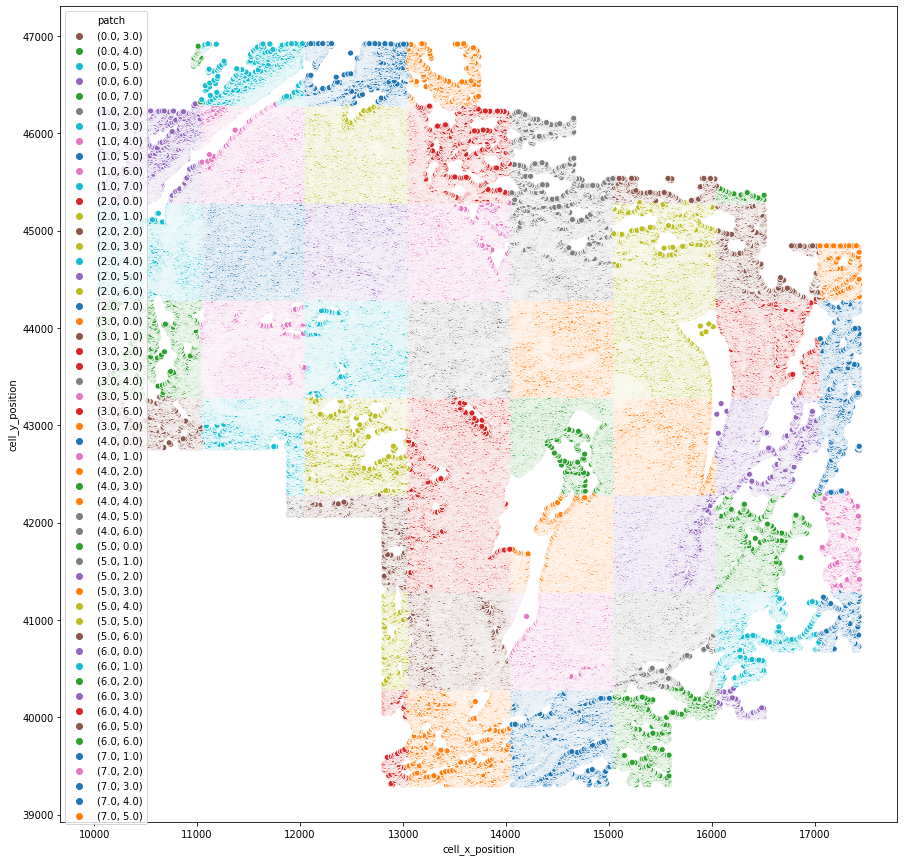

In [10]:
fig, ax = plt.subplots(figsize = (15,15))
unique = nodes_sorted_y["patch"].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
color = random.shuffle(sns.color_palette())

sns.scatterplot(data = nodes_sorted_y , x='cell_x_position', y= 'cell_y_position', hue = 'patch', palette =palette)
plt.savefig('./plots/patches_'+PATIENT_ID+'.png')

In [11]:
columns = ['cell_id','patch']
patch_mapping = nodes_sorted_y[columns]

## Assigning number for each patch

In [12]:
unique_patchs = nodes_sorted_y.groupby(['patch']).agg('count').reset_index()['patch'].values
patch_number = pd.DataFrame({'patch':unique_patchs, 'patch_number': range(len(unique_patchs))})

# Size patches

In [13]:
patch_sizes = pd.DataFrame(patch_mapping.patch.value_counts()).reset_index().rename(columns = {'index':'patch','patch':'patch_size'})

In [14]:
patch_mapping = patch_mapping.merge(patch_sizes, on='patch', how = 'left')

In [15]:
nodes_sorted_y['patch_size'] = patch_mapping['patch_size']

In [16]:
nodes = nodes_sorted_y.drop(['patch_x','patch_y'],axis=1)

In [17]:
nodes = nodes.merge(patch_number, on='patch', how='left')

In [18]:
nodes.head(2)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border,patch,patch_size,patch_number
0,1792,14076.7,39305.3,stroma,MISSING,True,"(4.0, 0.0)",3898,27
1,3,13421.3,39305.3,stroma,MISSING,False,"(3.0, 0.0)",5084,19


In [19]:
del nodes_sorted_x
del nodes_sorted_y

# Read edges

In [20]:
edges = pd.read_csv(OUTPUT_PATH + 'graph_edges.csv')

In [21]:
edges = edges.merge(patch_mapping , left_on = 'cell_id_1', right_on = 'cell_id', how='left')
edges = edges.merge(patch_mapping , left_on = 'cell_id_2', right_on = 'cell_id', how='left')

In [22]:
edges = edges.drop(['cell_id_x','cell_id_y','patch_size_y'], axis =1)
edges = edges.rename(columns={'patch_x':'patch_1','patch_y':'patch_2','patch_size_x':'patch_size'})

In [23]:
inter_patch = (edges.patch_1 != edges.patch_2).value_counts()[False]
intra_patch = (edges.patch_1 != edges.patch_2).value_counts()[True]
print('inter-patch edges: ',inter_patch )
print('intra-patch edges: ',intra_patch )

inter-patch edges:  795421
intra-patch edges:  14446


In [24]:
edges = edges[(edges.patch_1 == edges.patch_2)]
edges = edges.drop(['patch_2'], axis =1)
edges = edges.rename(columns ={'patch_1' : 'patch'})

In [25]:
edges = edges.merge(patch_number, on='patch', how='left')

# Patch filtering 

In [26]:
nodes = nodes[nodes.patch_size>SIZE_THRESHOLD]
edges = edges[edges.patch_size>SIZE_THRESHOLD]

## Localisation patches

In [162]:
localisation_columns = ['patch_number','patch', 'cell_x_position','cell_y_position']
localisation_nodes = nodes[localisation_columns]
localisation_patch = localisation_nodes.groupby(['patch']).agg('mean').reset_index()


## Number of border cells

In [163]:
border_grouped = nodes.groupby(['patch','on_border']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
on_border_grouped_pivotted = pd.pivot_table(border_grouped, values='count', index=['patch'],columns=['on_border'], aggfunc=np.sum).reset_index()
on_border_grouped_pivotted.columns.name = None
on_border_grouped_pivotted = on_border_grouped_pivotted.fillna(0)
on_border_grouped_pivotted = on_border_grouped_pivotted.rename(columns = {False:'out_of_border',True:'in_border'})


In [164]:
patch_data = localisation_patch.merge(on_border_grouped_pivotted, on='patch', how='left')

# Edge count per patch

In [165]:
edges = edges[(edges.phenotype_1 != 'MISSING') & (edges.phenotype_2 != 'MISSING')]

edge_phenotype_count = edges.groupby(['patch','phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

number_per_patch = edges.groupby(['patch']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'total_edge_per_patch'})

edge_phenotype_count = edge_phenotype_count.merge(number_per_patch,on='patch',how='left')

if NORMALISE_COUNT == True :
    edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']/edge_phenotype_count['total_edge_per_patch']

if NORMALISE_COUNT == False :
    edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']

    
edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

edge_phenotype_count = edge_phenotype_count[['patch','edge_count_ratio','edge_type']]


edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='edge_count_ratio', index=['patch'],
                    columns=['edge_type'], aggfunc=np.sum)

edge_phenotype_count_pivotted.columns.name = None
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)

columns = edge_phenotype_count_pivotted.columns[1:]


In [167]:
patch_data = patch_data.merge(edge_phenotype_count_pivotted, on='patch', how='left')

## Nodes regions  phenotype count

In [168]:
nodes['region'] = nodes.apply(lambda x : regions(x.tissue_category, x.on_border), axis =1)
nodes_grouped = nodes.groupby(['patch','region','phenotype']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
nodes_grouped['region_phenotype'] = nodes_grouped.apply(lambda row: row.region + '_region_' + row.phenotype , axis = 1)
nodes_grouped = nodes_grouped.merge(patch_sizes, on='patch', how ='left')
if NORMALISE_COUNT == True:
    nodes_grouped['count'] = nodes_grouped['count']/nodes_grouped['patch_size']
region_count_grouped_pivotted = pd.pivot_table(nodes_grouped, values='count', index=['patch'],columns=['region_phenotype'], aggfunc=np.sum).reset_index()
region_count_grouped_pivotted.columns.name = None
region_count_grouped_pivotted = region_count_grouped_pivotted.fillna(0)



In [169]:
patch_data = patch_data.merge(region_count_grouped_pivotted, on='patch', how='left')

# Defining Grid Graph

In [191]:
edges_data = patch_data[['patch_number','patch']].copy()
edges_data['key'] = 0

edges_data = edges_data.merge(edges_data, how = 'left', on = 'key')

edges_data['distance'] = edges_data.apply(lambda row: np.linalg.norm(np.array(row.patch_x) - np.array(row.patch_y)), axis=1)

edges_data = edges_data[edges_data['distance'] == 1]

edges_data = edges_data.drop(['key'], axis=1)
edges_data = edges_data.rename(columns={'patch_number_x':'patch_number_1','patch_x':'patch_1','patch_number_y':'patch_number_2','patch_y':'patch_2'})

edges_data.head(2)


,patch_number_1,patch_1,patch_number_2,patch_2,distance
1,0,"(0.0, 3.0)",1,"(0.0, 4.0)",1.0
6,0,"(0.0, 3.0)",6,"(1.0, 3.0)",1.0


In [192]:
len(edges_data)

180

# extracting for all Patients

In [21]:
Directory = os.getcwd()
Directory_path = Directory + '/data/output'
files = os.listdir(Directory_path)



for file in files[:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition == ''
        
    
    if condition == 'DEEPMEL':
        
        INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
        OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
        PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
        
        print('Treating patient : ' + PATIENT_ID )
        print('Reading nodes : ')
        nodes = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')
        
        nodes_sorted_x = nodes.sort_values(['cell_x_position'])
        
        shifted_x = nodes_sorted_x['cell_x_position'] - min(nodes_sorted_x['cell_x_position'])
        nodes_sorted_x['patch_x'] = shifted_x//PATCH_DIM_X
        
        nodes_sorted_y = nodes_sorted_x.sort_values(['cell_y_position'])
        shifted_y = nodes_sorted_y['cell_y_position'] - min(nodes_sorted_y['cell_y_position'])
        nodes_sorted_y['patch_y'] = shifted_y//PATCH_DIM_Y
        
        nodes_sorted_y['patch'] = nodes_sorted_y.apply(lambda row: (row.patch_x,row.patch_y), axis=1)
        
        print('number of patches : ', len(nodes_sorted_y.patch.unique()))
        
        columns = ['cell_id','patch']
        patch_mapping = nodes_sorted_y[columns]
        
        unique_patchs = nodes_sorted_y.groupby(['patch']).agg('count').reset_index()['patch'].values
        patch_number = pd.DataFrame({'patch':unique_patchs, 'patch_number': range(len(unique_patchs))})
        
        patch_sizes = pd.DataFrame(patch_mapping.patch.value_counts()).reset_index().rename(columns = {'index':'patch','patch':'patch_size'})
        
        patch_mapping = patch_mapping.merge(patch_sizes, on='patch', how = 'left')
        
        nodes_sorted_y['patch_size'] = patch_mapping['patch_size']
        nodes = nodes_sorted_y.drop(['patch_x','patch_y'],axis=1)
        nodes = nodes.merge(patch_number, on='patch', how='left')
        
        del nodes_sorted_x
        del nodes_sorted_y
        
        
        print('Reading edges... ')
        
        edges = pd.read_csv(OUTPUT_PATH + 'graph_edges.csv')
        
        edges = edges.merge(patch_mapping , left_on = 'cell_id_1', right_on = 'cell_id', how='left')
        edges = edges.merge(patch_mapping , left_on = 'cell_id_2', right_on = 'cell_id', how='left')
        
        edges = edges.drop(['cell_id_x','cell_id_y','patch_size_y'], axis =1)
        edges = edges.rename(columns={'patch_x':'patch_1','patch_y':'patch_2','patch_size_x':'patch_size'})
        
        inter_patch = (edges.patch_1 != edges.patch_2).value_counts()[False]
        intra_patch = (edges.patch_1 != edges.patch_2).value_counts()[True]
        print('inter-patch edges: ',inter_patch )
        print('intra-patch edges: ',intra_patch )
        
        edges = edges[(edges.patch_1 == edges.patch_2)]
        edges = edges.drop(['patch_2'], axis =1)
        edges = edges.rename(columns ={'patch_1' : 'patch'})
        
        edges = edges.merge(patch_number, on='patch', how='left')
        
        print('Patch filtering...')
        
        nodes = nodes[nodes.patch_size>SIZE_THRESHOLD]
        edges = edges[edges.patch_size>SIZE_THRESHOLD]
        print('number of patches remaining: ', len(nodes.patch.unique()))

        
        
        print('Localisation')
        localisation_columns = ['patch_number','patch', 'cell_x_position','cell_y_position']
        localisation_nodes = nodes[localisation_columns]
        localisation_patch = localisation_nodes.groupby(['patch']).agg('mean').reset_index()
        
        print('Region count')

        border_grouped = nodes.groupby(['patch','on_border']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
        on_border_grouped_pivotted = pd.pivot_table(border_grouped, values='count', index=['patch'],columns=['on_border'], aggfunc=np.sum).reset_index()
        on_border_grouped_pivotted.columns.name = None
        on_border_grouped_pivotted = on_border_grouped_pivotted.fillna(0)
        on_border_grouped_pivotted = on_border_grouped_pivotted.rename(columns = {False:'out_of_border',True:'in_border'})
        
        patch_data = localisation_patch.merge(on_border_grouped_pivotted, on='patch', how='left')
        
        edges = edges[(edges.phenotype_1 != 'MISSING') & (edges.phenotype_2 != 'MISSING')]

        
        print('Edge count')

        edge_phenotype_count = edges.groupby(['patch','phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

        number_per_patch = edges.groupby(['patch']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'total_edge_per_patch'})

        edge_phenotype_count = edge_phenotype_count.merge(number_per_patch,on='patch',how='left')

        if NORMALISE_COUNT == True :
            edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']/edge_phenotype_count['total_edge_per_patch']

        if NORMALISE_COUNT == False :
            edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']

    
        edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

        edge_phenotype_count = edge_phenotype_count[['patch','edge_count_ratio','edge_type']]


        edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='edge_count_ratio', index=['patch'],
                    columns=['edge_type'], aggfunc=np.sum)

        edge_phenotype_count_pivotted.columns.name = None
        edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
        edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)
        
        
        patch_data = patch_data.merge(edge_phenotype_count_pivotted, on='patch', how='left')
        
        print('Region phenotype count')

        
        nodes['region'] = nodes.apply(lambda x : regions(x.tissue_category, x.on_border), axis =1)
        nodes_grouped = nodes.groupby(['patch','region','phenotype']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
        nodes_grouped['region_phenotype'] = nodes_grouped.apply(lambda row: row.region + '_region_' + row.phenotype , axis = 1)
        nodes_grouped = nodes_grouped.merge(patch_sizes, on='patch', how ='left')
        if NORMALISE_COUNT == True:
            nodes_grouped['count'] = nodes_grouped['count']/nodes_grouped['patch_size']
        region_count_grouped_pivotted = pd.pivot_table(nodes_grouped, values='count', index=['patch'],columns=['region_phenotype'], aggfunc=np.sum).reset_index()
        region_count_grouped_pivotted.columns.name = None
        region_count_grouped_pivotted = region_count_grouped_pivotted.fillna(0)

        
        patch_data = patch_data.merge(region_count_grouped_pivotted, on='patch', how='left')
        
        
        patch_data.to_csv(OUTPUT_PATH + 'patch_data.csv', index = False)
        
        print('Extracting Grid Graph Edges')
        
        edges_data = patch_data[['patch_number','patch']].copy()
        edges_data['key'] = 0

        edges_data = edges_data.merge(edges_data, how = 'left', on = 'key')

        edges_data['distance'] = edges_data.apply(lambda row: np.linalg.norm(np.array(row.patch_x) - np.array(row.patch_y)), axis=1)

        edges_data = edges_data[edges_data['distance'] == 1]

        edges_data = edges_data.drop(['key'], axis=1)
        edges_data = edges_data.rename(columns={'patch_number_x':'patch_number_1','patch_x':'patch_1','patch_number_y':'patch_number_2','patch_y':'patch_2'})

       

        edges_data.to_csv(OUTPUT_PATH + 'patch_edge_data.csv', index = False)

        
        
        


Treating patient : 2P1
Reading nodes : 
number of patches :  169
Reading edges... 
inter-patch edges:  2374686
intra-patch edges:  36720
Patch filtering...
number of patches remaining:  169
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 3I1
Reading nodes : 
number of patches :  255
Reading edges... 
inter-patch edges:  2511779
intra-patch edges:  47886
Patch filtering...
number of patches remaining:  255
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 1F1
Reading nodes : 
number of patches :  50
Reading edges... 
inter-patch edges:  315248
intra-patch edges:  4677
Patch filtering...
number of patches remaining:  50
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 1L1
Reading nodes : 
number of patches :  65
Reading edges... 
inter-patch edges:  1556230
intra-patch edges:  28737
Patch filtering...
number of patch

number of patches remaining:  211
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 1K1
Reading nodes : 
number of patches :  17
Reading edges... 
inter-patch edges:  686645
intra-patch edges:  9807
Patch filtering...
number of patches remaining:  17
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 3M1
Reading nodes : 
number of patches :  373
Reading edges... 
inter-patch edges:  7943553
intra-patch edges:  133980
Patch filtering...
number of patches remaining:  373
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 2T1
Reading nodes : 
number of patches :  37
Reading edges... 
inter-patch edges:  606964
intra-patch edges:  11607
Patch filtering...
number of patches remaining:  37
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 3G1
Reading nodes : 
number of 

Reading edges... 
inter-patch edges:  3701577
intra-patch edges:  68437
Patch filtering...
number of patches remaining:  164
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 3A1
Reading nodes : 
number of patches :  172
Reading edges... 
inter-patch edges:  3234363
intra-patch edges:  51939
Patch filtering...
number of patches remaining:  172
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 2Q1
Reading nodes : 
number of patches :  48
Reading edges... 
inter-patch edges:  1269860
intra-patch edges:  21806
Patch filtering...
number of patches remaining:  48
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 3H1
Reading nodes : 
number of patches :  358
Reading edges... 
inter-patch edges:  7294509
intra-patch edges:  115912
Patch filtering...
number of patches remaining:  358
Localisation
Region count
Edge count
Regio